<a href="https://colab.research.google.com/github/nihal-rao/detectron2_experiments/blob/master/Hand_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [0]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 15kB/s 
     |████████████████████████████████| 4.1MB 47.5MB/s 
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
     |████████████████████████████████| 276kB 5.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=d5b49bc8ada68da4fa9eb59b12151b081d79cb9e31abafd0ef0451de9929e183
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ikski5q3
  Running command git 

In [0]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 6.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.dev200410-cp36-none-any.whl size=38762 sha256=4bb283933ec87a324770e2a9852bf9786c4c9ebed8732866418f4fd129bbb673
  Stored in directory: /root/.cache/pip/wheels/1b/f3/7f/c5b04e55c170323900f35020bd21f8e5aeb6fb436b95a66d23
Successfully built fvcore


In [0]:
import numpy as np
import os
import cv2
import random
from google.colab.patches import cv2_imshow
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


##Loading data

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:

from detectron2.data.datasets import register_coco_instances
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

register_coco_instances("ego_train", {}, "/content/drive/My Drive/egohands/instances_hands_train2020.json", "/content/drive/My Drive/egohands/train_images")
register_coco_instances("ego_val", {}, "/content/drive/My Drive/egohands/instances_hands_test2020.json", "/content/drive/My Drive/egohands/test_images")

rpc_train_metadata = MetadataCatalog.get("ego_train")
val_metadata = MetadataCatalog.get("ego_val")


[03/21 04:03:05 d2.data.datasets.coco]: Loaded 600 images in COCO format from /content/drive/My Drive/egohands/instances_hands_test2020.json


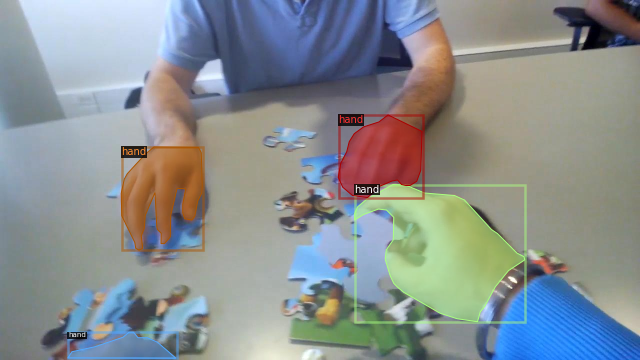

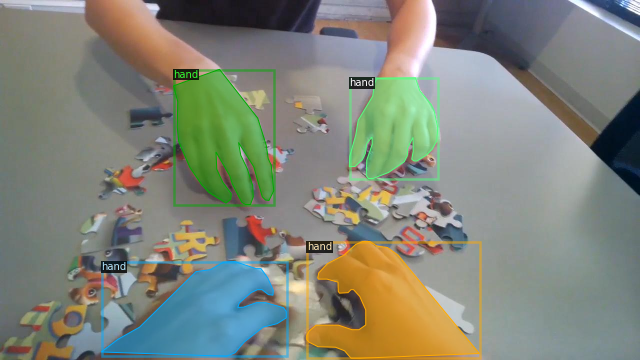

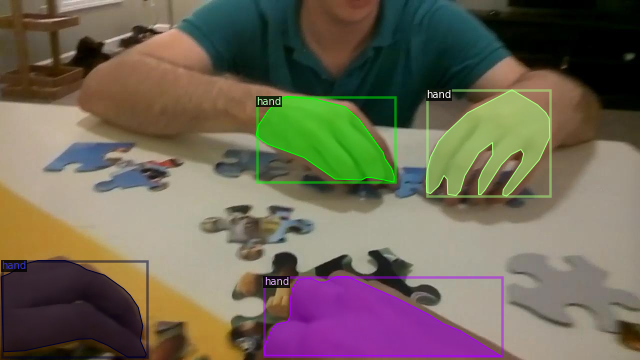

In [0]:
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get("ego_val")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=rpc_val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train


In [0]:
import torch 
import detectron2.utils.comm as comm

class ValidationLoss(detectron2.engine.HookBase):
    def __init__(self, config):
        super(ValidationLoss, self).__init__()
        self.cfg = config.clone()
        self.cfg.DATASETS.TRAIN = config.DATASETS.VAL
        self._loader = iter(detectron2.data.build_detection_train_loader(self.cfg))

    def after_step(self):
      batch =  next(self._loader) 
      with torch.no_grad():
        loss_dict = self.trainer.model(batch)
        loss_dict_reduced = {"val_" + k: v.item() for k, v in 
                                 comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
          self.trainer.storage.put_scalars(total_val_loss=losses_reduced, 
                                                 **loss_dict_reduced)     


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ego_train",)
cfg.DATASETS.VAL = ("ego_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2

cfg.SOLVER.BASE_LR = 0.001 # pick a good LR
#cfg.SOLVER.GAMMA = 0.5
#cfg.SOLVER.STEPS = (500,1000,2000,2500,3000,4000)
cfg.SOLVER.MAX_ITER = 2000  
cfg.SOLVER.WARMUP_ITERS = 10
cfg.MODEL.RETINANET.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
val_loss = ValidationLoss(cfg)  
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[04/10 13:05:28 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

model_final_4cafe0.pkl: 152MB [00:02, 54.2MB/s]                           
'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (9, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (9,) in the model! Skipped.


[04/10 13:05:35 d2.engine.train_loop]: Starting training from iteration 0
[04/10 13:06:19 d2.utils.events]:  eta: 0:05:50  iter: 19  total_loss: 1.049  loss_cls: 0.814  loss_box_reg: 0.224  total_val_loss: 0.991  val_loss_cls: 0.844  val_loss_box_reg: 0.209  time: 0.1784  data_time: 1.3732  lr: 0.001000  max_mem: 2125M
[04/10 13:06:29 d2.utils.events]:  eta: 0:05:52  iter: 39  total_loss: 0.415  loss_cls: 0.291  loss_box_reg: 0.144  total_val_loss: 0.413  val_loss_cls: 0.263  val_loss_box_reg: 0.150  time: 0.1833  data_time: 0.0078  lr: 0.001000  max_mem: 2125M
[04/10 13:06:39 d2.utils.events]:  eta: 0:05:48  iter: 59  total_loss: 0.246  loss_cls: 0.168  loss_box_reg: 0.071  total_val_loss: 0.341  val_loss_cls: 0.251  val_loss_box_reg: 0.131  time: 0.1837  data_time: 0.0106  lr: 0.001000  max_mem: 2126M
[04/10 13:06:49 d2.utils.events]:  eta: 0:05:47  iter: 79  total_loss: 0.204  loss_cls: 0.139  loss_box_reg: 0.063  total_val_loss: 0.324  val_loss_cls: 0.225  val_loss_box_reg: 0.103  

In [0]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model


In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
"""
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ego_train",)
"""
cfg.MODEL.WEIGHTS = os.path.join('/content/output', "model_final.pth")
#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   #set the testing threshold for this model
#cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.9
cfg.DATASETS.TEST = ("ego_val", )
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
predictor = DefaultPredictor(cfg)

[04/10 14:28:28 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

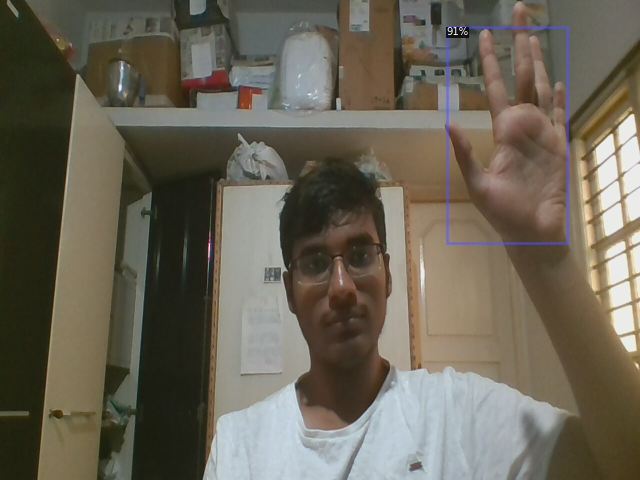

In [0]:
im = cv2.imread('/content/drive/My Drive/hand_rcnn_101/3.jpg')
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=rpc_val_metadata, 
                   scale=0.5, 
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
import shutil
shutil.copytree('/content/output', '/content/drive/My Drive/hand_retinanet_res_50')

'/content/drive/My Drive/hand_retinanet_res_50'

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("ego_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ego_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[04/10 13:25:32 d2.data.datasets.coco]: Loaded 600 images in COCO format from /content/drive/My Drive/egohands/instances_hands_test2020.json
[04/10 13:25:32 d2.data.common]: Serializing 600 elements to byte tensors and concatenating them all ...
[04/10 13:25:32 d2.data.common]: Serialized dataset takes 1.29 MiB
[04/10 13:25:32 d2.evaluation.evaluator]: Start inference on 600 images
[04/10 13:25:34 d2.evaluation.evaluator]: Inference done 11/600. 0.0797 s / img. ETA=0:00:49
[04/10 13:25:39 d2.evaluation.evaluator]: Inference done 71/600. 0.0796 s / img. ETA=0:00:44
[04/10 13:25:44 d2.evaluation.evaluator]: Inference done 129/600. 0.0810 s / img. ETA=0:00:40
[04/10 13:25:49 d2.evaluation.evaluator]: Inference done 190/600. 0.0807 s / img. ETA=0:00:34
[04/10 13:25:54 d2.evaluation.evaluator]: Inference done 250/600. 0.0809 s / img. ETA=0:00:29
[04/10 13:25:59 d2.evaluation.evaluator]: Inference done 309/600. 0.0808 s / img. ETA=0:00:24
[04/10 13:26:04 d2.evaluation.evaluator]: Inference d

OrderedDict([('bbox',
              {'AP': 71.8187502533341,
               'AP50': 97.34281031573195,
               'AP75': 88.32469949255099,
               'APl': 73.7444748179382,
               'APm': 48.221601721872474,
               'APs': 16.151647724449145})])